# Identifying Instruments in Irish Traditional Music Samples : Using a Neural Network for Sound Identification

**Author** : 
Peter Nielson

**Supervising Instructor** :  
Dr. Steve Beaty, MSU Denver

**Abstract :**

Projects such as Dr. Martin Tourish’s “Musical Catalyst Framework” (as outlined in his 2013 doctoral thesis, “In Process and Practice: The Development of an Archive of Explicit Stylistic Data for Irish Traditional Instrumental Music”), where the choice of musical instrument changes the stylistic context in the performed piece, create implementation questions regarding the importance of the individual instrument in the automated classification process.  Unfortunately, identifying instruments in the context of “folk music” is incredibly domain specific with little crossover computationally.  The classifier trained here aims to identify an instrument from a given set (button accordion, fiddle, flute, penny whistle, and uilleann pipes) to act as a preprocessing mechanism for future classifiers that are trained specifically to the style of the instrument.  The necessary steps, then, to work on this (and most) sound based classifiers is to gather the data (audio samples of playing), preprocess the data so it is fit to be trained upon, and train a neural network as a classifier to predict the primary instrument present in any sample of Irish Traditional Music.  The tools used to achieve this are “SoX - Sound eXchange”, “TensorFlow”, “Keras”, and “NumPy”, with the languages of choice being “Python 3.6” and the “Bash scripting language.

After completing these tasks, around 500 samples were collected and a classifier was created with 88% accuracy on new “test” audio files and a 97% accuracy on the training set.  Furthermore, with new samples completely outside of the training and test sets, the classifier quite accurately predicts on all instruments except for the penny whistle, which is often misclassified as the fiddle.  The results from this classifier are certainly suitable enough to be used as the aforementioned preprocessing technique to determine the instrument prior to using a stylistic classifier, though the results could certainly be improved by adding more data samples and balancing out the label distribution.

------

## Procedure

The first step in creating this classifier was to find appropriate audio samples that primarily featured the instrument.  A goal for this was to find varied samples of different rhythms, recording qualities, and styles so that the neural net could learn and  filter out the noise to determine what it sees as making the sound of a particular instrument unique.  These were gathered from my own personal collection of Irish Traditional Music.


Artists included in the samples are:

###  **Accordion**
-  Billy McComiskey
-  Brendan Begley (and Caoimhin O'Rialliagh)
-  Jackie Daly
-  Jerry O'Brien
-  Joe Cooley
-  Joe Derrane
-  Johnny O'Leary
-  Paul Brock

### **Fiddle**
-  Andy McGann (and Paul Brady)
-  Athena Tergis
-  Bobby Casey
-  Brendan Mulvihill (and Donna Long)
-  Brid Harper (and others)
-  Claire Egan
-  Colin Farrell
-  Eugene O'Donnell
-  Frankie Gavin
-  Hugh Gillespie
-  John Carty
-  Johnny Doherty
-  Johnny Henry
-  Kevin Burke
-  Liz Carroll (and John Doyle)
-  MacDara O'Riaghliagh
-  Matt Cranitch
-  Martin Byrnes
-  Martin Hayes
-  Michael Coleman
-  Musicians from the Frank Kilkelly Guitar CD
-  Oisin MacDiarmada
-  Paddy Glackin
-  Paddy Killoran and James Morrison
-  Paddy Reynolds (and  Paul Brady)
-  Tommy Peoples
-  Tommy Potts

### **Flute**
-  Billy Clifford
-  Cathal McConnell
-  Desi Wilkinson
-  Fintan Vallely
-  Grey Larsen
-  Larry Nugent
-  Michael McGouldrick
-  Seamus Tansey

### **Pennywhistle**
-  Donnacha O'Briain
-  Gavin Whelan
-  Joanie Madden
-  Mary Bergin
-  Micho Russell

### **Uilleann Pipes**
-  Davy Spillane (and Kevin Glackin)
-  Jerry O'Sullivan
-  Joey Abarta
-  John McSherry
-  Liam O'Flynn
-  Preston Howard
-  Seamus Ennis
-  Tomas O'Cannain
-  Tommy Martin

_While there are many artists listed here, some may not have made it to the final training or testing set._

-----

Due to the libraries that are used later, we do not need to convert the audio files to any specific format.  But, we should ensure the files are in the `data/instruments/` directory as such:
```
├── data
    ├── instruments
        ├── accordion
        ├── fiddle
        ├── flute
        ├── pennywhistle
        ├── uilleann

```

This structure helps a later program ensure only the files and directories are used, ignoring hidden files and folders.


The files all should be trimmed as well to be 30 seconds long (through prior experimentation, it seems that this file length is short enough to both convey the necessary information in the training process and not take up too much space in memory).  

The provided dataset should have the files trimmed to the necessary length, but if one wants to use their own data, the following script should be run.  The `SoX -- Sound eXchange` command  line tool is necessary to run this code*.

_*To run the following code in Jupyter, remove the markdown code and change the format to 'code'_

_It was found that good samples of the music could be found ~20 seconds into the sample._
_From the command line, the script name is `trimFiles.sh`_

```bash
%%bash
#!/bin/bash

cd data/instruments/

echo "Collecting 30 second snippets from various tunes"

declare -i total=0

for fname in *
do

  echo "Looking at $fname"
  if [ -d "$fname" ]
  then

    echo "Trimming files in $fname to be 30 seconds long (20s-50s)..."
    cd "$fname"
    declare -i number=0

    for f in *.mp3
    do
      echo "Trimming file number: $number..."
      echo "Filename: $f"

      sox "$f" "$fname$number.mp3" trim 20 30
      (( ++number ))
      (( ++total ))
    done
    cd ..

    echo
    echo 
    echo "Trimmed $number items from $fname"
    echo
    echo "Total trimmed so far => $total"

  fi
done

cd ../../
```

After ensuring that the files were all preprocessed, you should manually do a train-test split.  Python's scikit-learn library has a built in-function, but due to the pennywhistle and overall collection's small size, ensuring there is a good balance between labels.

If more samples are obtained for all the instruments, this train-test split process could be moved to be automated by the library.

So, arbitrarily select the files for testing from the training set and place them into new instrument folders in a folder adjacent to the previously created `data/instruments` folder as such:

```
├── data
    ├── instruments
    ├── test
        ├── instruments
            ├── accordion
            ├── fiddle
            ├── flute
            ├── pennywhistle
            ├── uilleann
```

With this, I can now more programatically preprocess the files.

I first tried the most obvious method of converting sound to a more easily processable format, the Fast Fourier Transform (FFT).  This algorithm is important to sound analysis and it collapses periodic signals (sound in this case) making them easier to process computationally.

In [1]:
import time
from pathlib import Path
import numpy as np
import scipy
import librosa

# The training and test directories
INS_DIR = 'data/instruments'
TEST_DIR = 'data/test/instruments'

INSTRUMENTS = ['accordion', 'fiddle', 'flute', 'pennywhistle', 'uilleann']


def generate_fft(instruments=INSTRUMENTS, base_dir=INS_DIR):
    data = []
    labels = []
    print("Number of Samples per Instrument in %s:" % (base_dir))
    
    for label, instrument in enumerate(instruments):
        ins_dir = Path(base_dir) / instrument
        num_labels = 0
        # Since I do know the file type of the files
        # I am simply globbing them all as mp3s
        for fname in ins_dir.glob(str(instrument)+'*.*'):
            X, sample_rate = librosa.core.load(fname)
            fft_features = abs(scipy.fft(X, sample_rate))
            
            data.append(fft_features)
            labels.append(label)
            
            num_labels += 1
        print('\t%i %s samples' % (num_labels, instrument))
    
    print()
    return np.array(data), np.array(labels)
         

start_time = time.time()

X_train, y_train = generate_fft()
X_test, y_test = generate_fft(base_dir=TEST_DIR)

end_time = time.time()

print('X_train => Rows: %d, Columns: %d' % (X_train.shape[0], X_train.shape[1]))
print('X_test  => Rows: %d, Columns: %d' % (X_test.shape[0], X_test.shape[1]))
preprocess_time = end_time-start_time
print('\nTime Taken: %s seconds' % (preprocess_time))

Number of Samples per Instrument in data/instruments:
	81 accordion samples
	80 fiddle samples
	80 flute samples
	72 pennywhistle samples
	76 uilleann samples

Number of Samples per Instrument in data/test/instruments:
	20 accordion samples
	20 fiddle samples
	20 flute samples
	17 pennywhistle samples
	19 uilleann samples

X_train => Rows: 389, Columns: 22050
X_test  => Rows: 96, Columns: 22050

Time Taken: 517.6243929862976 seconds


The problem here, though, is that the FFT algorithm expects a relatively regular signal with minimal "noise", and while music can be somewhat repetitive to our ears at times, there may be almost imperceptable and subtle changes that "irregularize" the wave.  Additionally, many of the music samples have considerable noise.

As we can see, there are slightly fewer pennywhistle and uilleann samples  than the rest.  This is due to my own collection having slightly fewer examples of those instruments.

Additionally, the preprocessing for this took a little less than nine  minutes to complete, giving us 389 samples to train on and 96 samples to test on.

I need to still preprocess a tiny bit to speed up the training process more by one-hot encoding the labels.

In [2]:
import tensorflow as tf
import tensorflow.keras as keras


# Get the one-hot encoded labels
y_train_onehot = keras.utils.to_categorical(y_train)

print('First 3 labels:', y_train[:3])
print('First 3 labels (one-hot):\n', y_train_onehot[:3])

First 3 labels: [0 0 0]
First 3 labels (one-hot):
 [[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


Now I'll build the model with keras, a framework for creating neural networks with TensorFlow.

In [3]:
np.random.seed(4)
tf.set_random_seed(4)

model = keras.models.Sequential()

model.add(keras.layers.Dense(units=100, input_dim=X_train.shape[1],
                             kernel_initializer='glorot_uniform',
                             bias_initializer='zeros',
                             activation='selu'))

model.add(keras.layers.Dense(units=100, input_dim=100,
                             kernel_initializer='glorot_uniform',
                             bias_initializer='zeros',
                             activation='relu'))

model.add(keras.layers.Dense(units=y_train_onehot.shape[1], input_dim=100,
                             kernel_initializer='glorot_uniform',
                             bias_initializer='zeros',
                             activation='softmax'))

sgd_optimizer = keras.optimizers.SGD(lr=0.001, decay=1e-8, momentum=.9)
adadelta_optimizer = keras.optimizers.Adadelta()
rms_prop_optimizer = keras.optimizers.RMSprop()
nadam_optimizer = keras.optimizers.Nadam()

model.compile(optimizer=adadelta_optimizer, loss='categorical_crossentropy')

# Set verbose to 1 here to see a more detailed output
history = model.fit(X_train, y_train_onehot,
                    batch_size=100, epochs=20, verbose=0,
                    validation_split=0.1)

y_train_pred = model.predict_classes(X_train, verbose=0)
correct_preds = np.sum(y_train == y_train_pred, axis=0)
train_acc = correct_preds / y_train.shape[0]

print('Training accuracy: %.2f%%' % (train_acc * 100))

y_test_pred = model.predict_classes(X_test, verbose=0)
correct_preds = np.sum(y_test == y_test_pred, axis=0)
test_acc = correct_preds / y_test.shape[0]

print('Test accuracy: %.2f%%' % (test_acc * 100))



Training accuracy: 20.57%
Test accuracy: 20.83%



----
The accuracy here is unfortunately quite low, as one should expect based on what the FFT done for preprocessing should use.  Unfortunately, though, the results are inconsistent, ranging from a test accuracy of 20-62%.  This usually signifies that the classifier never really reaches a good minima, which could be for a variety of reasons.

Let's try doing a Grid Search to tune the hyperparameters.

In [4]:
import sklearn
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier


def create_model(learn_rate=0.01, momentum=0.9, optimizer='sgd', activation_one='selu', activation_two='relu', activation_three='softmax', loss='binary_crossentropy'):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(units=100, input_dim=X_train.shape[1],
                                 kernel_initializer='glorot_uniform',
                                 bias_initializer='zeros',
                                 activation=activation_one))
    
    model.add(keras.layers.Dense(units=100, input_dim=100,
                                 kernel_initializer='glorot_uniform',
                                 bias_initializer='zeros',
                                 activation=activation_two))
    
    model.add(keras.layers.Dense(units=y_train_onehot.shape[1], input_dim=100,
                                 kernel_initializer='glorot_uniform',
                                 bias_initializer='zeros',
                                 activation=activation_three))
    
    optimizer_dict = {
        'sgd'      :  keras.optimizers.SGD(lr=learn_rate, decay=1e-7, momentum=momentum),
        'adadelta' :  keras.optimizers.Adadelta(),
        'rmsprop'  :  keras.optimizers.RMSprop(),
        'adagrad'  :  keras.optimizers.Adagrad(),
        'adam'     :  keras.optimizers.Adam(),
        'adamax'   :  keras.optimizers.Adamax(),
        'nadam'    :  keras.optimizers.Nadam()
    }
    
    model.compile(optimizer=optimizer_dict[optimizer], loss=loss, metrics=['accuracy'])
    
    return model

activation_functions = ['selu', 'relu', 'sigmoid', 'softmax']

param_grid = {
    #'learn_rate'        : [0.01, 0.005, 0.001, 0.0005, 0.0001],
    #'momentum'          : [0.1, 0.2, 0.5, 0.8, 0.9],
    'epochs'            : [50],
    #'epochs'            : [10, 20, 25, 40, 50, 60, 75, 80, 90, 100],
    #'batch_size'        : [10, 20, 30, 40, 60, 80, 100, 200, 300, 350],
    'activation_one'    : activation_functions,
    'activation_two'    : activation_functions,
    'activation_three'  : activation_functions,
    #'optimizer'         : ['sgd', 'adadelta', 'rmsprop', 'adagrad', 'adam', 'adamax', 'nadam'],
    #'loss'              : ['categorical_crossentropy', 'binary_crossentropy']
}

model = KerasClassifier(build_fn=create_model, verbose=0, validation_split=0.1)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, iid=True)
grid_result = grid.fit(X_train, y_train_onehot)

Using TensorFlow backend.


In [5]:
print('Best: %f%%' % (grid_result.best_score_*100))
print('Params: ')
for param in grid_result.best_params_:
    print('%s :\t %s' % (param, grid_result.best_params_[param]))

Best: 80.308484%
Params: 
activation_one :	 relu
activation_three :	 sigmoid
activation_two :	 softmax
epochs :	 50


With ~14 minutes within a Grid Search, received some parameters to get us to 80% accuracy.  Let's do some more Grid Searches to see if we can do better.

In [6]:
param_grid = {
    'learn_rate'        : [0.01, 0.005, 0.001, 0.0005, 0.0001],
    'epochs'            : [10, 25, 50, 75, 100, 200],
    'activation_one'    : ['selu'],
    'activation_two'    : ['sigmoid'],
    'activation_three'  : ['relu'],
}

model = KerasClassifier(build_fn=create_model, verbose=0, validation_split=0.1)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, iid=True)
grid_result = grid.fit(X_train, y_train_onehot)

In [9]:
print('Best: %f%%' % (grid_result.best_score_*100))
print('Params: ')
for param in grid_result.best_params_:
    print('%s :\t %s' % (param, grid_result.best_params_[param]))

Best: 73.470437%
Params: 
activation_one :	 selu
activation_three :	 relu
activation_two :	 sigmoid
epochs :	 25
learn_rate :	 0.0001


6 minutes.

Another observation on this data  is that, in terms of the number of feature columns, it is massive (over 22 thousand).

Let's now try graphing the data

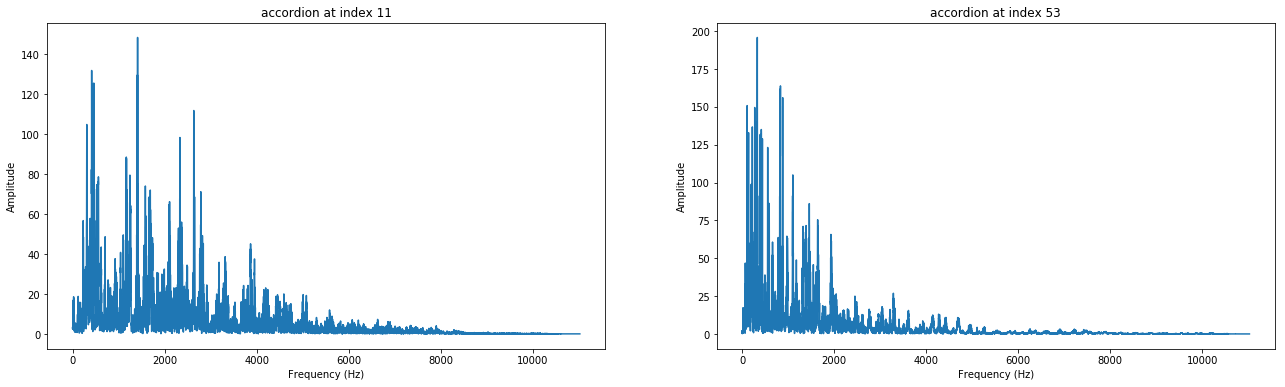

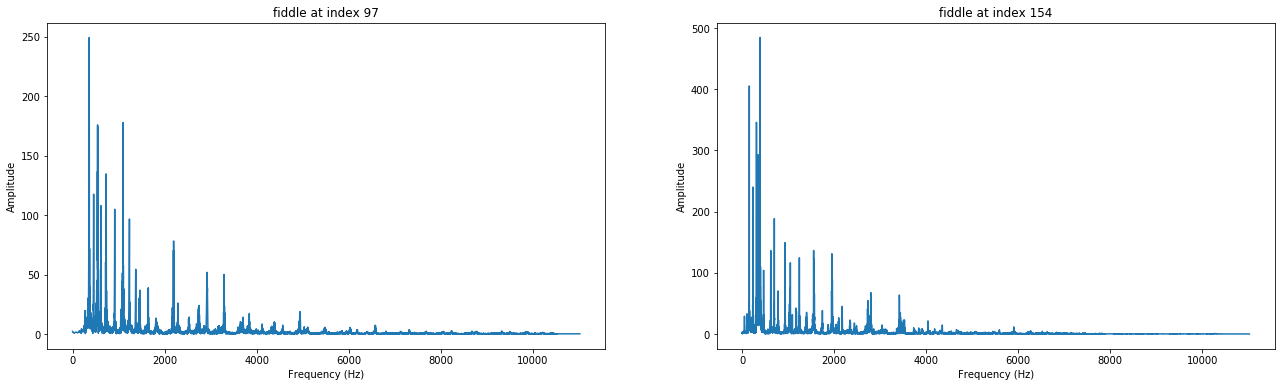

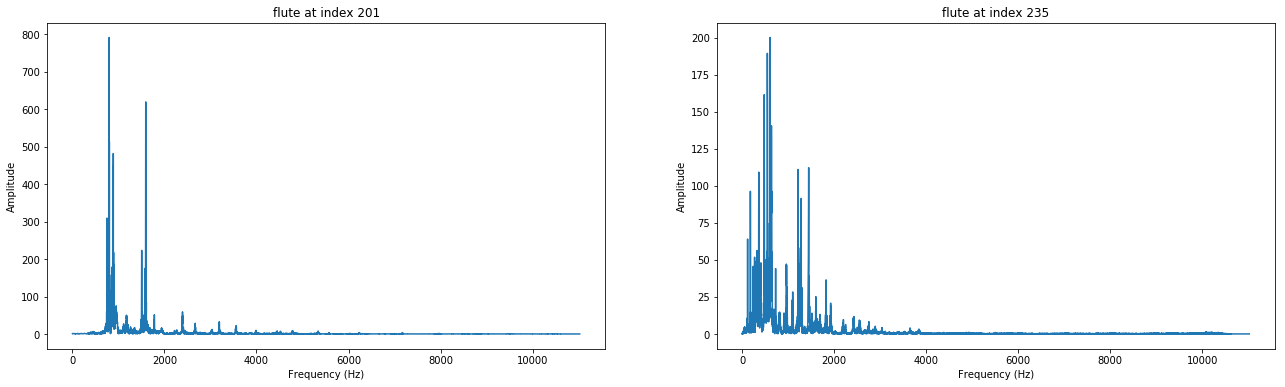

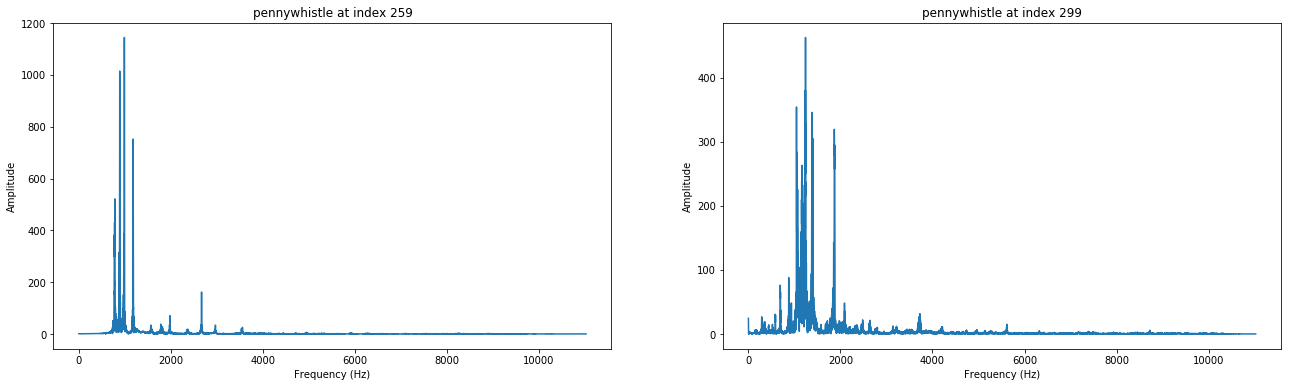

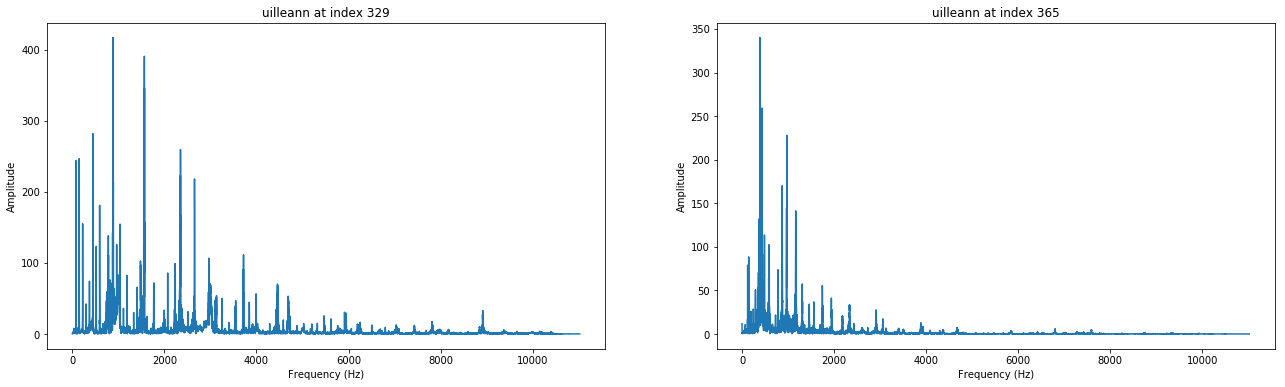

In [55]:
import matplotlib.pyplot as plt

sample_indices = [np.random.randint(0, 39), np.random.randint(40, 80), 
                  np.random.randint(81, 120), np.random.randint(121, 161),
                  np.random.randint(162, 241), np.random.randint(162, 241),
                  np.random.randint(242, 263), np.random.randint(264, 313),
                  np.random.randint(314, 335), np.random.randint(336, 389)]

indices = np.array(range(len(X_train[index]+1)//2))

alt = False

for index in sample_indices:
    if alt == False:
        plt.figure(figsize=(22,6))
        plt.subplot(121)
    else:
        plt.subplot(122)
    plt.plot(indices, X_train[index][0:len(X_train[index]+1)//2])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.title(INSTRUMENTS[y_train[index]] + ' at index ' + str(index))
    if alt == False:
        alt = True
    else:
        alt = False
        plt.show()

As was noted earlier, Fast-Fourier Transforms do not work incredibly well for non-uniform musical samples (or those which cannot be graphed with a simple sine function).

The above graphs are direct graphs of the FFTs.  Two quick observations are that the data only really extends to  ~11,000 Hz, but most music does not hold frequencies that high, and that more than half of the data of each sample sits near zero and is effectively useless for the model.

Another observation is that the distinction between much of the data is fairly minimal, with accordion and the  uilleann pipes looking fairly similar, and the flute and pennywhistle samples also appearing very similar.

FFT does work fairly well, but, it seems like there may be something better.

----

So, the next method for audio processing is **MFCC**, or the **Mel-Frequency Cepstrum Coefficient**.  This process still uses an inverse Fourier Transform, but the overall process tends to create a simpler set of data.  Additionally, the MFCC process does tend to be suceptible to noise, but the features it shows tend to be good for non-uniform audio classification like speech recognition, hence it's use here for music.

In [ ]:
from python_speech_features import mfcc

# Storing the old fft data for later comparisons
fft_X_train, fft_y_train = X_train, y_train
fft_X_test, fft_y_test = X_test, y_test


def generate_ceps(instruments=INSTRUMENTS, base_dir=INS_DIR):
    data = []
    labels = []
    print("Number of Samples per Instrument in %s:" % (base_dir))
    
    for label, instrument in enumerate(instruments):
        ins_dir = Path(base_dir) / instrument
        num_labels = 0

        for fname in ins_dir.glob(str(instrument)+'*.*'):
            X, sample_rate = librosa.core.load(fname)
            ceps_features = mfcc(X)
            num_ceps = len(ceps)
            
            # Average per coefficient over all frames for better generalization and
            # better noise reduction
            data.append(np.mean(ceps_features[num_ceps//2:(num_ceps*9)//10], axis=0))
            labels.append(label)
            num_labels += 1
            
        print('\t%i %s samples' % (num_labels, instrument))
    
    print()
    return np.array(data), np.array(labels)


start_time = time.time()

X_train, y_train = generate_ceps()
X_test, y_test = generate_ceps(base_dir=TEST_DIR)

end_time = time.time()

print('X_train => Rows: %d, Columns: %d' % (X_train.shape[0], X_train.shape[1]))
print('X_test  => Rows: %d, Columns: %d' % (X_test.shape[0], X_test.shape[1]))
preprocess_time = end_time-start_time
print('\nTime Taken: %s seconds' % (preprocess_time))